In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Robot in SE(2) 

<p>First, we design the shape we are going to control in this case a square-like shape with a propeller in each corner pointing in an arbitrary direction as follows</p>

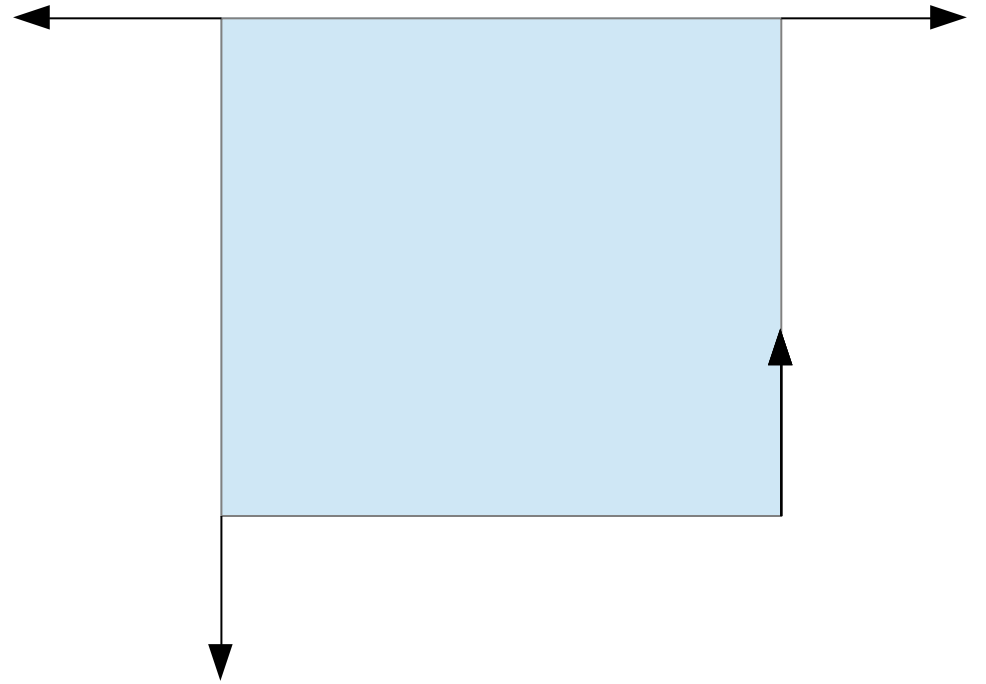
Then the state variables are $\mathbf{x}=[x,z,\theta]$
<p> The first step is drawing a box in python with the following function</p>

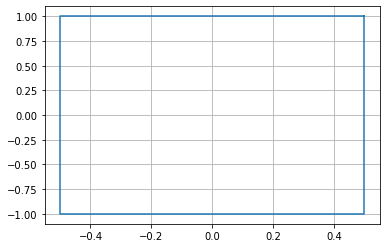

In [2]:
def box_points(w, h):
    points = np.zeros([5,3])
    points[0] = [ + w/2, 0, + h/2]
    points[1] = [ + w/2, 0, - h/2]
    points[2] = [ - w/2, 0, - h/2]
    points[3] = [ - w/2, 0, + h/2]
    points[4] = [ + w/2, 0, + h/2]
    return points

box = box_points(1, 2)  

plot(box[:,0], box[:,2])
grid()

Once we have the box is neccesary to be able to rotate it and translate it in the cartesian plane 

In [3]:
RotY = lambda θ: [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]

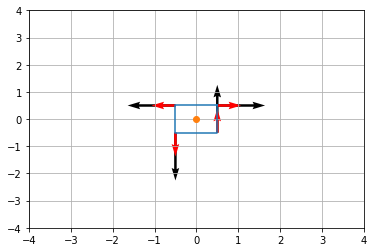

In [4]:
def box_se2(x, z, θ, u=[0,0], w=1, h=1, angs=array([0, -pi/2, pi/2, -pi]), ax=plt.axes()):
    points = box_points(w, h)
#     θ= -θ
    # Rotation matrix
    R = [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]
#     for p in points:
#         print(p)
#     print(a)
    # Rotate
    points = [np.dot(R, p) for p in points]
#     print(points)
    points = array(points)
#     print(points)
    
    # translate
    points[:,0] += x
    points[:,2] += z
    #angs = array(angs)
    angs += θ
    # propellers
    e1 = [1,0,0]    
    prop_x = array([np.dot(RotY(ang), e1)[0] for ang in angs])
    prop_z = array([np.dot(RotY(ang), e1)[2] for ang in angs])
#     prop_x = array([sin(θ), sin(θ)])
#     prop_z = array([cos(θ), cos(θ)])
        
    # Plot propellers
    #points[0,0] -= w/2
#     p3 = points[0,0] + w/2
#     px = concatenate((p3,points[1:3,0]), axis=None)
    px = points[0:4,0]
    pz = points[0:4,2]
    #print(px,pz)
    ax.quiver(px, pz, prop_x, prop_z, scale=7)
    
    ax.plot(points[:,0], points[:,2])
    # control input    
    ax.quiver(px, pz, u*prop_x, u*prop_z, scale=7, color='r')
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))
#     return points
angle = 0* pi/180
x, z, θ = 0,0, angle
# box_se2(0, 0, 0, [3,3], w=2, h=2)
# x, z, θ = 1,1, 0
box_se2(x, z, θ, [0.5,0.5,0.5,0.5], w=1, h=1)


plot(x,z, 'o')
grid()

In [5]:
def simulate(Δt, x, dx):   
    x += Δt * dx
    return x

##  Definition matrix A

The actuation on the system is given by $\mathbf{w}= \mathbf{A}\mathbf{u}$, where $\mathbf{w}$ is the wrench, $\mathbf{u}$ is the control inputs and $\mathbf{A}$ is the desing matrix that depends on the location and direction of the propellers, for this case we consider a matrix with three propellers and a matrix with four propellers. Here, $\mathbf{w}=[\mathbf{f}_x, \mathbf{f}_z, \tau ]$, then considering the design with three propellers matrix $\mathbf{A}$ is defined as

$
A=\begin{bmatrix}
\cos(\alpha_1) &\cos(\alpha_2)  & \cos(\alpha_3)\\ 
\sin(\alpha_1) & \sin(\alpha_2) & \sin(\alpha_3)\\ 
\mathbf{p}_1 \times \mathbf{f}_1 & \mathbf{p}_2 \times \mathbf{f}_2 & \mathbf{p}_3 \times \mathbf{f}_3
\end{bmatrix}
$

and for the case of four propellers as de design above 

$A_2=\begin{bmatrix}
\cos(\alpha_1) &\cos(\alpha_2)  & \cos(\alpha_3) & \cos(\alpha_4)\\ 
\sin(\alpha_1) & \sin(\alpha_2) & \sin(\alpha_3) & \sin(\alpha_4)\\ 
\mathbf{p}_1 \times \mathbf{f}_1 & \mathbf{p}_2 \times \mathbf{f}_2 & \mathbf{p}_3 \times \mathbf{f}_3& \mathbf{p}_4 \times \mathbf{f}_4
\end{bmatrix}$
where $p_i$ is the location of each propeler and $f_i$ is the force generated

Then we can find eigenvalues and eigenvectors of the matrices and also its ranks, note that $A_2$ is not full rank.

In [6]:
angs=array([0, -pi/2, pi/2, -pi])
w, h = 1, 1
points = box_points(w, h)
px, pz = points[0:4,0], points[0:4,2]
print(points[0:4,0], points[0:4,2])

A2 = array([(cos(angs[0]), cos(angs[1]), cos(angs[2]), cos(angs[3])),
           (sin(angs[0]), sin(angs[1]), sin(angs[2]), sin(angs[3])),
           (pz[0]*cos(angs[0])-px[0]*sin(angs[0]),
           pz[1]*cos(angs[1])-px[1]*sin(angs[1]),
           pz[2]*cos(angs[2])-px[2]*sin(angs[2]),
           pz[3]*cos(angs[3])-px[3]*sin(angs[3]))])

A = array([(cos(angs[0]), cos(angs[1]), cos(angs[2])),
           (sin(angs[0]), sin(angs[1]), sin(angs[2])),
           (pz[0]*cos(angs[0])-px[0]*sin(angs[0]),
           pz[1]*cos(angs[1])-px[1]*sin(angs[1]),
           pz[2]*cos(angs[2])-px[2]*sin(angs[2]))])
#print(A2)
rank = np.linalg.matrix_rank(A)
rank2 = np.linalg.matrix_rank(A2)
ei_values, ei_vectors = np.linalg.eig(A)
print('rank of A:', rank, 'rank of A2:', rank2, ' its eigenvalues: ', ei_values, ' its eigenvectors: ',ei_vectors)
# A2inv = inv(A)
A2inv = np.linalg.pinv(A2)
Ainv = inv(A)
print('A inverse:',Ainv)
print('A2 inverse:', A2inv)


[ 0.5  0.5 -0.5 -0.5] [ 0.5 -0.5 -0.5  0.5]
rank of A: 3 rank of A2: 3  its eigenvalues:  [ 1.          0.78077641 -1.28077641]  its eigenvectors:  [[-4.08248290e-01 -5.01435290e-16 -1.34097551e-17]
 [-4.08248290e-01  4.89633738e-01 -9.62769686e-01]
 [-8.16496581e-01  8.71928209e-01  2.70323013e-01]]
A inverse: [[ 1.0000000e+00  0.0000000e+00 -1.2246468e-16]
 [-5.0000000e-01 -5.0000000e-01  1.0000000e+00]
 [-5.0000000e-01  5.0000000e-01  1.0000000e+00]]
A2 inverse: [[ 5.00000000e-01 -1.29315261e-16 -2.59485599e-16]
 [-5.00000000e-01 -5.00000000e-01  1.00000000e+00]
 [-5.00000000e-01  5.00000000e-01  1.00000000e+00]
 [-5.00000000e-01  6.80829207e-17 -9.11970350e-17]]


## State variables and parameter definition

Lets define gravity vector as $\mathbf{g} = [0, 0, -9.8]$, robot mass $m=1$, robot inertia as $\mathbf{J}=\mathbf{I}_3$ where $\mathbf{I}_3$ is the identity matrix of dimension 3. State vector as $\mathbf{x}=[x,z,\theta,\dot{x}, \dot{z}, \dot{\theta}]^{\top}$, initial conditions as $\mathbf{x} = [0, 0, 0, 0, 0, 0]^{\top}$, and desired state vector as $\mathbf{x}^{d} = [2, 3, \pi/2, 0, 0, 0]$

In [22]:
# z unit vector
e3 = np.array([0,0,1])
g = [0, 0, -9.8]
m = 1
Iy = 1
tf = 12.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

kpx, kvx, kpz, kvz, kpθ, kvθ = 1, 3, 1, 2, 2, 4
# Desired state
xd = np.array([2, 3, pi/2, 0., 0., 0.])
x = np.array([0, 0, 0, 0., 0., 0.])
dx = np.array([0, 0, 0, 0., 0., 0.])

x_log = [copy(x)]
u_log = [[0, 0, 0, 0]]

## Dynamics

$
\begin{bmatrix}
\dot{\mathbf{v}}\\
\boldsymbol{\dot{\omega}}
\end{bmatrix}=\begin{bmatrix}
\frac{1}{m} {}^w\mathbf{R}_b& 0\\ 
0 & \mathbf{J}^{-1} 
\end{bmatrix}\mathbf{Au}+\begin{bmatrix}
g\\ 
\mathbf{J}^{-1}(\mathbf{J}\boldsymbol{\omega} \times \boldsymbol{\omega})
\end{bmatrix}
$

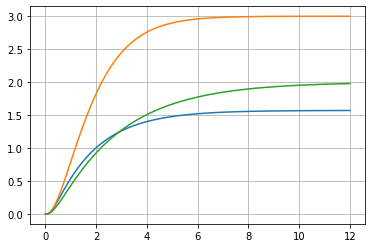

In [23]:


for t in time[1:]:
    px, pz, pθ, vx, vz, vθ = x
    pxd, pzd, pθd, vxd, vzd, vθd = xd 
    
    # PD controller         
    ax = (pxd - px) * kpx + (vxd-vx) * kvx
    az = (pzd - pz) * kpz + (vzd-vz) * kvz
    aθ = (pθd - pθ) * kpθ + (vθd-vθ) * kvθ
    a = array([ax, az, aθ])
    
    w = [m * ax, m * az, Iy * aθ]  
    B1 = [[cos(pθ)/m, sin(pθ)/m, 0], 
          [-sin(pθ)/m, cos(pθ)/m, 0],
         [0, 0, 1/Iy]]
    B = np.dot(B1,A)
    B2 = np.dot(B1,A2)
    
    Binv = inv(B)
    B2inv = np.linalg.pinv(B2)
    u = np.dot(B2inv,(a + g))

#     # Dynamics
    a = np.dot(B2,u) - g
    dx[:3] = x[3:]
    dx[3:] = a
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(copy(u))
    
x_log = array(x_log)
u_log = array(u_log)

grid()
plot(time, x_log[:,2], label='$x$')
plot(time, x_log[:,1], label='$x$')
plot(time, x_log[:,0], label='$x$')


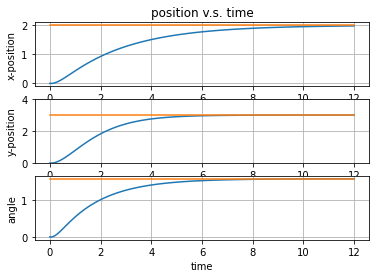

In [24]:
fig = plt.figure()
ax11 = fig.add_subplot(311)
ax11.grid()
ax11.set_ylabel('x-position')
ax11.set_xlabel('time')
ax11.set_title('position v.s. time')
ax11.plot(time, x_log[:,0])
ax11.plot(time, xd[0]*np.ones(len(time)))

ax12 = fig.add_subplot(312)
ax12.grid()
ax12.set_ylabel('y-position')
ax12.set_xlabel('time')
ax12.set_ylim((0, 4))
ax12.plot(time, x_log[:, 1])
ax12.plot(time, xd[1]*np.ones(len(time)))

ax13 = fig.add_subplot(313)
ax13.grid()
ax13.set_ylabel('angle')
ax13.set_xlabel('time')
ax13.plot(time, x_log[:, 2])
ax13.plot(time, xd[2]*np.ones(len(time)))




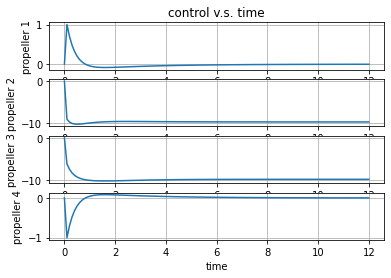

In [21]:
fig2 = plt.figure()
ax11 = fig2.add_subplot(411)
ax11.grid()
ax11.set_ylabel('propeller 1')
ax11.set_xlabel('time')
ax11.set_title('control v.s. time')
ax11.plot(time, u_log[:,0])


ax12 = fig2.add_subplot(412)
ax12.grid()
ax12.set_ylabel('propeller 2')
ax12.set_xlabel('time')
ax12.plot(time, u_log[:, 1])


ax13 = fig2.add_subplot(413)
ax13.grid()
ax13.set_ylabel('propeller 3')
ax13.set_xlabel('time')
ax13.plot(time, u_log[:, 2])

ax14 = fig2.add_subplot(414)
ax14.grid()
ax14.set_ylabel('propeller 4')
ax14.set_xlabel('time')
ax14.plot(time, u_log[:, 3])



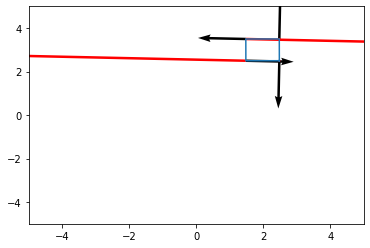

In [22]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()



def animate(t):
    ax.clear()       
        
    px, pz, θ, vx, vz, vθ = x_log[t]
    u = u_log[t]
    #print(u)
    # box points
    box_se2(px, pz, θ, u, w=1, h=1, ax=ax)

 
    # Initial conditions
    ax.plot(t, x_log[t,0],  'bo')
    ax.set_xlim((-5., 5.))
    ax.set_ylim((-5.,5.))
    

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)
HTML(anim.to_jshtml())